# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 3
### David Larsson & Jonas Lundgren

## Collecting a Dataset

Code from https://github.com/pnugues/edan95.

In [21]:
import os
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline  

In [2]:
# To create the same dataset
random.seed(0)

original_dataset_dir = "flowers-recognition/flowers"
dataset = "flowers-recognition/flowers_split"

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]

pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
    
random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))


for image, label in train_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(train_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in val_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(validation_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in test_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(test_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

Image types: ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower']
2595
865
866


## Building a Simple Convolutional Neural Network

Chceck some random flowers

daisy


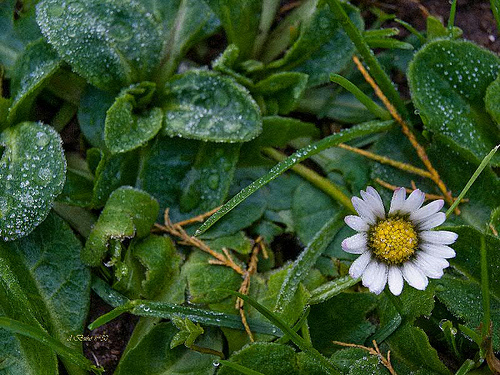

sunflower


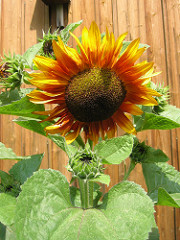

sunflower


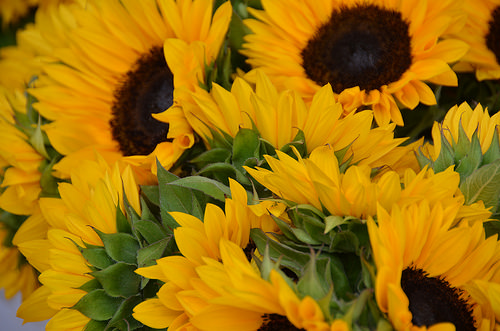

daisy


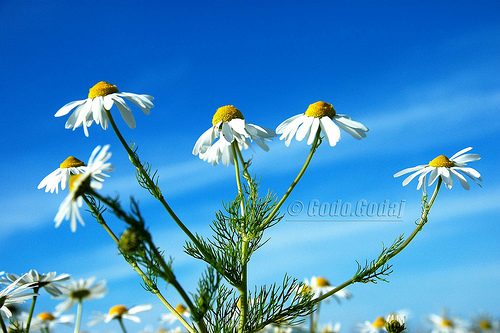

daisy


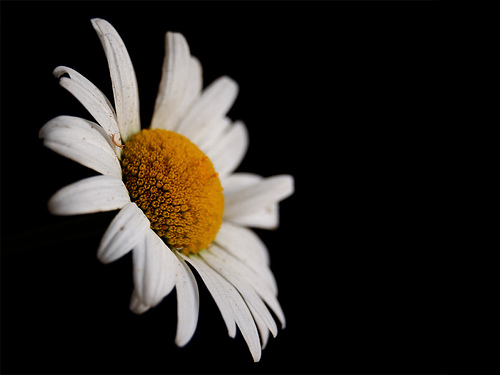

In [4]:
num_flowers = 5
random_flowers_idx = np.random.randint(0, len(train_images), num_flowers)
random_flowers = [train_images[i] for i in random_flowers_idx]

for image, label in random_flowers:
    src = os.path.join(train_dir, label, image)
    print(label)
    display(Image(filename=src))
    #im = Image.open(src)
    #im.show()


### 1.1 

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [8]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

In [9]:
train_datagen = ImageDataGenerator(rescale = 1. / 255)
val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle = False,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [15]:
retrain_model = False

In [12]:
if retrain_model:
    history = model.fit_generator(train_generator,
                                  steps_per_epoch = 129,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 43)

Epoch 1/30
129/129 [==============================] - 72s 557ms/step - loss: 1.4217 - acc: 0.3689 - val_loss: 1.3210 - val_acc: 0.4605
Epoch 2/30
129/129 [==============================] - 74s 574ms/step - loss: 1.1671 - acc: 0.5031 - val_loss: 1.0866 - val_acc: 0.5243
Epoch 3/30
129/129 [==============================] - 75s 584ms/step - loss: 1.0626 - acc: 0.5632 - val_loss: 1.5212 - val_acc: 0.5290
Epoch 4/30
129/129 [==============================] - 75s 579ms/step - loss: 1.0020 - acc: 0.5908 - val_loss: 1.0248 - val_acc: 0.5515
Epoch 5/30
129/129 [==============================] - 75s 579ms/step - loss: 0.9472 - acc: 0.6218 - val_loss: 1.0437 - val_acc: 0.6000
Epoch 6/30
129/129 [==============================] - 74s 572ms/step - loss: 0.8985 - acc: 0.6417 - val_loss: 0.9388 - val_acc: 0.6272
Epoch 7/30
129/129 [==============================] - 74s 573ms/step - loss: 0.8336 - acc: 0.6749 - val_loss: 0.7919 - val_acc: 0.6509
Epoch 8/30
129/129 [==============================] - 7

In [12]:
if retrain_model:
    model.save_weights('model_1_lab3.model')
else:
    model.load_weights('model_1_lab3.model')

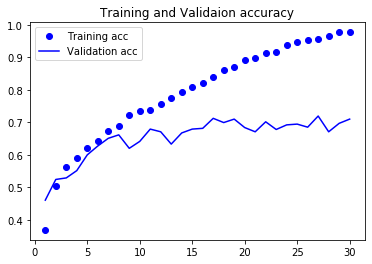

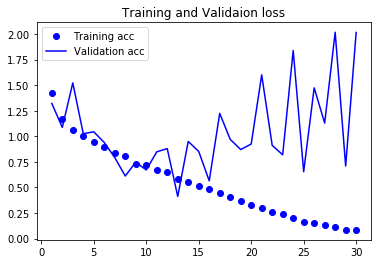

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

### 1.2

In [13]:
y_hat = model.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [14]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.6867052023121387
Confusion Matrix :
 [[167  22   9   9  21]
 [ 18 118  11  10   5]
 [ 14  16  89  48  19]
 [  5  18  20 100   6]
 [ 10   2   7   1 120]]


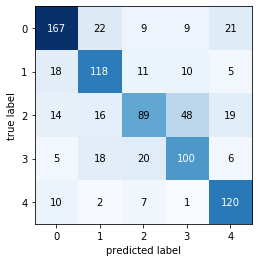

In [44]:
plot_confusion_matrix(cm);

### 1.3

Added 1 more layer and dropout for last layer.

In [45]:
model2 = models.Sequential()
model2.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model2.add(layers.MaxPool2D(pool_size = (2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation = 'relu'))
model2.add(layers.Dense(5, activation = 'softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

Using Adam as optimizer.

In [46]:
model2.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.adam(lr = 1e-4),
              metrics = ['acc'])

In [19]:
if retrain_model:
    history = model2.fit_generator(train_generator,
                                  steps_per_epoch = 129,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 43)

Epoch 1/30
129/129 [==============================] - 72s 555ms/step - loss: 1.5337 - acc: 0.3107 - val_loss: 1.1957 - val_acc: 0.4035
Epoch 2/30
129/129 [==============================] - 71s 551ms/step - loss: 1.2567 - acc: 0.4247 - val_loss: 1.3527 - val_acc: 0.4533
Epoch 3/30
129/129 [==============================] - 71s 549ms/step - loss: 1.1734 - acc: 0.4891 - val_loss: 1.2771 - val_acc: 0.5018
Epoch 4/30
129/129 [==============================] - 72s 561ms/step - loss: 1.1412 - acc: 0.5248 - val_loss: 1.1636 - val_acc: 0.5586
Epoch 5/30
129/129 [==============================] - 71s 547ms/step - loss: 1.0705 - acc: 0.5562 - val_loss: 0.9196 - val_acc: 0.5740
Epoch 6/30
129/129 [==============================] - 71s 552ms/step - loss: 1.0283 - acc: 0.5705 - val_loss: 1.1370 - val_acc: 0.5846
Epoch 7/30
129/129 [==============================] - 71s 549ms/step - loss: 1.0107 - acc: 0.5912 - val_loss: 0.5574 - val_acc: 0.6095
Epoch 8/30
129/129 [==============================] - 7

In [47]:
if retrain_model:
    model2.save_weights('model_2_lab3.model')
else:
    model2.load_weights('model_2_lab3.model')

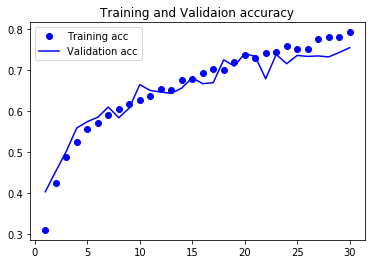

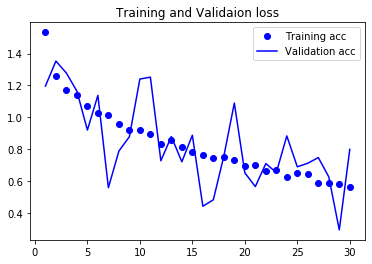

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [73]:
y_hat = model2.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [74]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.7375722543352601
Confusion Matrix :
 [[188   8   9   9  14]
 [ 22 120   7   6   7]
 [ 11  13 124  29   9]
 [ 17  10  32  86   4]
 [ 10   2   6   2 120]]


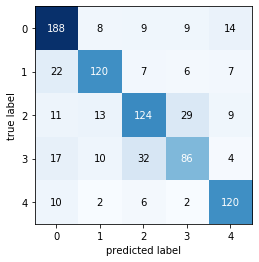

In [75]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);

### 2.1

In [63]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

Example image.

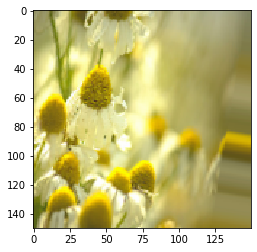

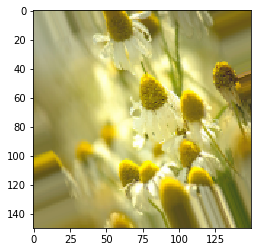

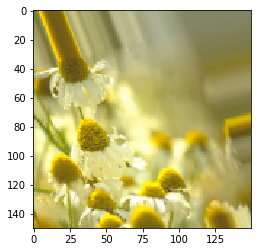

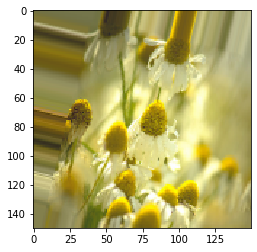

In [64]:


jpg, label = random_flowers[0]
img_path = os.path.join(train_dir, label, jpg)
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

for i, batch in zip(range(4), datagen.flow(x, batch_size = 1)):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
                    
plt.show()

In [65]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)


val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [66]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle = False,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [67]:
model3 = models.Sequential()
model3.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model3.add(layers.MaxPool2D(pool_size = (2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation = 'relu'))
model3.add(layers.Dense(5, activation = 'softmax'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 128)      

In [68]:
model3.compile(loss = 'categorical_crossentropy',
               optimizer = optimizers.RMSprop(lr = 1e-4),
               metrics = ['acc'])

In [30]:
if retrain_model:
    history = model3.fit_generator(train_generator,
                                  steps_per_epoch = 129,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 43)

Epoch 1/30
129/129 [==============================] - 77s 594ms/step - loss: 1.3901 - acc: 0.3810 - val_loss: 1.1386 - val_acc: 0.4872
Epoch 2/30
129/129 [==============================] - 76s 587ms/step - loss: 1.1954 - acc: 0.4942 - val_loss: 1.0938 - val_acc: 0.5290
Epoch 3/30
129/129 [==============================] - 76s 588ms/step - loss: 1.1295 - acc: 0.5299 - val_loss: 1.1457 - val_acc: 0.5787
Epoch 4/30
129/129 [==============================] - 76s 588ms/step - loss: 1.0636 - acc: 0.5706 - val_loss: 1.4303 - val_acc: 0.5586
Epoch 5/30
129/129 [==============================] - 76s 590ms/step - loss: 1.0367 - acc: 0.5787 - val_loss: 1.0816 - val_acc: 0.5456
Epoch 6/30
129/129 [==============================] - 76s 586ms/step - loss: 0.9973 - acc: 0.6009 - val_loss: 0.9512 - val_acc: 0.6071
Epoch 7/30
129/129 [==============================] - 76s 588ms/step - loss: 0.9743 - acc: 0.6071 - val_loss: 1.0146 - val_acc: 0.6118
Epoch 8/30
129/129 [==============================] - 7

In [69]:
if retrain_model:
    model3.save_weights('model_3_lab3.model')
else:
    model3.load_weights('model_3_lab3.model')

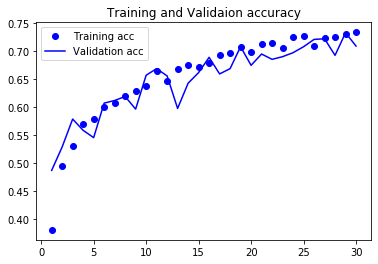

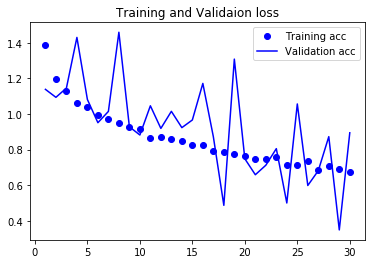

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [70]:
y_hat = model3.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [71]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.7260115606936416
Confusion Matrix :
 [[162  15  12  15  24]
 [ 11 119  10  12  10]
 [  3   7 113  48  15]
 [  4  13  21 103   8]
 [  3   3   3   0 131]]


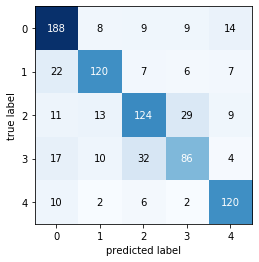

In [76]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);

## 3.1 Using a Pretrained Convolutional Base

From Chollet, Listing 5.11

In [7]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [9]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(directory,
                                            target_size = (150,150),
                                            batch_size = 20,
                                            classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                            class_mode = 'categorical')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 2740)
validation_features, validation_labels = extract_features(validation_dir, 860)
test_features, test_labels = extract_features(test_dir, 860)

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [11]:
train_features = train_features.reshape(2740, -1)
validation_features = validation_features.reshape(860, -1)
test_features = test_features.reshape(860, -1)

In [13]:
model4 = models.Sequential()
#model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(512, activation = 'relu', input_dim = 3*3*2048))
model4.add(layers.Dense(5, activation = 'softmax'))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 2565      
Total params: 9,440,261
Trainable params: 9,440,261
Non-trainable params: 0
_________________________________________________________________


In [41]:
model4.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history = model4.fit(train_features, 
                     train_labels, epochs = 30,
                     batch_size = 20,
                     validation_data = (validation_features, validation_labels))

Train on 2740 samples, validate on 860 samples
Epoch 1/30
2740/2740 [==============================] - 11s 4ms/step - loss: 5.7759 - accuracy: 0.6153 - val_loss: 0.7170 - val_accuracy: 0.7733
Epoch 2/30
2740/2740 [==============================] - 11s 4ms/step - loss: 0.7975 - accuracy: 0.7661 - val_loss: 0.7455 - val_accuracy: 0.7965
Epoch 3/30
2740/2740 [==============================] - 10s 4ms/step - loss: 0.6186 - accuracy: 0.8208 - val_loss: 0.6516 - val_accuracy: 0.8302
Epoch 4/30
2740/2740 [==============================] - 10s 4ms/step - loss: 0.4529 - accuracy: 0.8533 - val_loss: 0.8786 - val_accuracy: 0.7942
Epoch 5/30
2740/2740 [==============================] - 11s 4ms/step - loss: 0.3289 - accuracy: 0.8978 - val_loss: 0.6622 - val_accuracy: 0.8267
Epoch 6/30
2740/2740 [==============================] - 10s 4ms/step - loss: 0.3371 - accuracy: 0.9131 - val_loss: 0.8695 - val_accuracy: 0.8267
Epoch 7/30
2740/2740 [==============================] - 10s 4ms/step - loss: 0.2475

In [16]:
if retrain_model:
    model4.save_weights('model_4_lab3.model')
else:
    model4.load_weights('model_4_lab3.model')

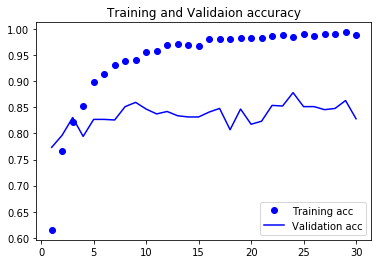

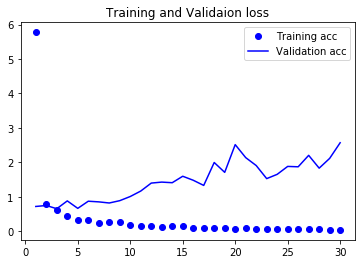

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [17]:
y_hat = model4.predict(test_features)
y_pred = np.argmax(y_hat, axis = 1)
y = np.argmax(test_labels, axis = 1)

In [22]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.8023255813953488
Confusion Matrix :
 [[187  14   2   2  21]
 [  8 119   2   7  23]
 [  4   5 129  27  21]
 [  3   1  11 126   8]
 [  2   1   2   6 129]]


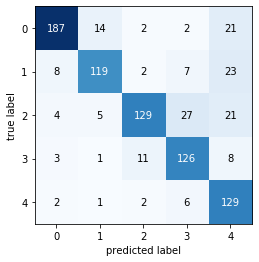

In [23]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);

### Modify to be able to take augmentied data.

In [24]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

model5 = models.Sequential()
model5.add(conv_base)
model5.add(layers.Flatten())
#model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(128, activation = 'relu', input_dim = 3*3*2048))
model5.add(layers.Dense(5, activation = 'softmax'))

model5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 24,162,853
Trainable params: 24,128,421
Non-trainable params: 34,432
_________________________________________________________________


In [25]:
len(model5.trainable_weights)

192

In [26]:
conv_base.trainable = False

In [27]:
len(model5.trainable_weights)

4

In [28]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [29]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle = False,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [52]:
model5.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

if retrain_model:
    history = model5.fit_generator(train_generator,
                                   steps_per_epoch = 129,
                                   epochs = 10, 
                                   validation_data = validation_generator,
                                   validation_steps = 43)

Epoch 1/10
129/129 [==============================] - 109s 843ms/step - loss: 2.0945 - accuracy: 0.4771 - val_loss: 1.4977 - val_accuracy: 0.4186
Epoch 2/10
129/129 [==============================] - 115s 889ms/step - loss: 1.1055 - accuracy: 0.5915 - val_loss: 3.1312 - val_accuracy: 0.5314
Epoch 3/10
129/129 [==============================] - 105s 818ms/step - loss: 0.9896 - accuracy: 0.6470 - val_loss: 2.5043 - val_accuracy: 0.5882
Epoch 4/10
129/129 [==============================] - 114s 883ms/step - loss: 0.9176 - accuracy: 0.6606 - val_loss: 1.6687 - val_accuracy: 0.6225
Epoch 5/10
129/129 [==============================] - 119s 922ms/step - loss: 0.8789 - accuracy: 0.6780 - val_loss: 1.5189 - val_accuracy: 0.6024
Epoch 6/10
129/129 [==============================] - 127s 981ms/step - loss: 0.8468 - accuracy: 0.6932 - val_loss: 2.1042 - val_accuracy: 0.6284
Epoch 7/10
129/129 [==============================] - 125s 971ms/step - loss: 0.8400 - accuracy: 0.6870 - val_loss: 1.6595 -

In [30]:
if retrain_model:
    model5.save_weights('model_5_lab3.model')
else:
    model5.load_weights('model_5_lab3.model')

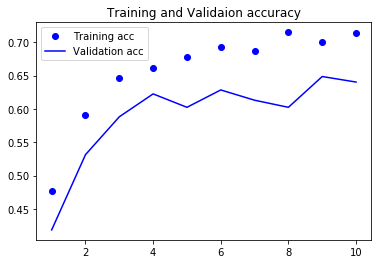

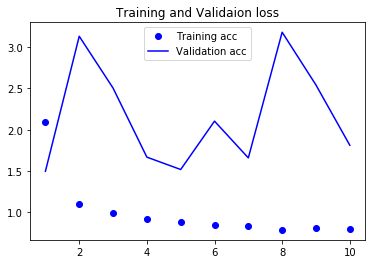

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [31]:
y_hat = model5.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis = 1)
y = test_generator.classes

In [32]:
print('Accuracy :', accuracy_score(y,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y, y_pred))

Accuracy : 0.6127167630057804
Confusion Matrix :
 [[ 66  70  10   3  79]
 [  1 146   2   5   8]
 [  4  10 122  22  28]
 [  1   5  27 105  11]
 [  3  38   4   4  91]]


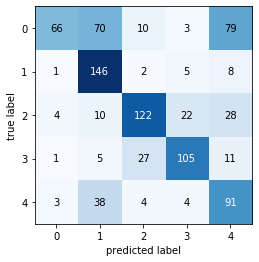

In [33]:
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm);